In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [3]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_reg_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_reg_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'reg_bias')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'unreg_bias')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly', regex=True)
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf', regex=True)
    
    filtered_cv_results[['C', 'fit_time', 'accuracy', 'n_iter']] = cv_results[[
        'param_C', 'mean_fit_time', 'mean_train_accuracy', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)

    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [4]:
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data

lin_X, lin_y = generate_linearly_separable_overlap_data(random_state=123456)
nonlin_X, nonlin_y = generate_nonlinearly_separable_data(random_state=123456)

## Hinge loss

### Primal formulation

In [5]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import plot_svm_hyperplane, plot_model_loss

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [6]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    
    if hasattr(svc, 'train_loss_history'):
        
        # (f_t - f^*) / f^*
        f_star = np.full_like(svc.train_loss_history, svc.loss.f_star())
        train_loss_history[svc.momentum_type][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                                 np.maximum(abs(f_star), 1))
        
    return {'accuracy': svc.score(X, y),
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(lin_X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits


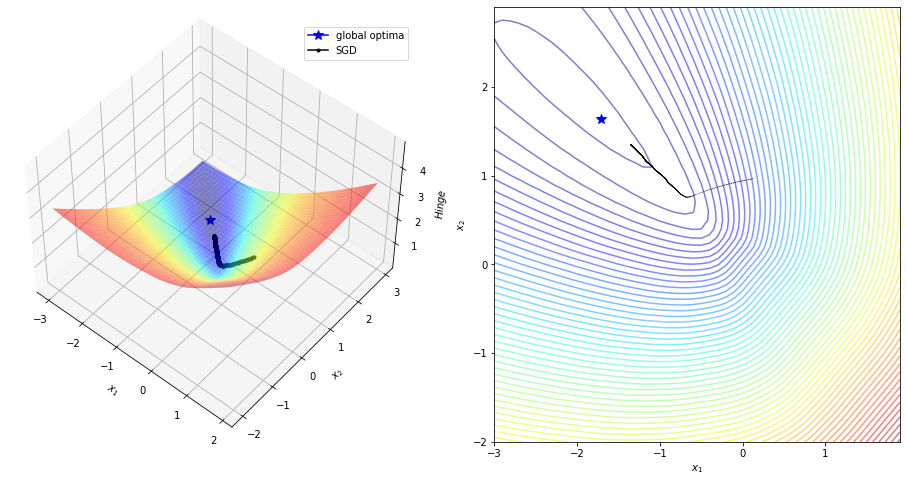

In [16]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

grid.best_estimator_.loss.x_opt = grid.best_estimator_.loss.x_star()[:-1] # remove the intercept weight to plot in 2D
grid.best_estimator_.loss.X = grid.best_estimator_.loss.X[:, :-1]  # remove the intercept column to plot in 2D
hinge_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                  x_min=-3, x_max=2, y_min=-2, y_max=3)
hinge_loss_opt = plot_trajectory_optimization(hinge_loss, grid.best_estimator_.optimizer, 
                                              color='k', label='SGD')

In [17]:
none_primal_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_l1_svc_cv_results.insert(0, 'solver', 'sgd')
none_primal_l1_svc_cv_results.insert(1, 'momentum', 'none')
none_primal_l1_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    none     0.1   0.325569     0.970    1000    50
                1.0   0.358418     0.985    1000    24
                10.0  0.358465     0.980     947    10

Fitting 1 folds for each of 3 candidates, totalling 3 fits


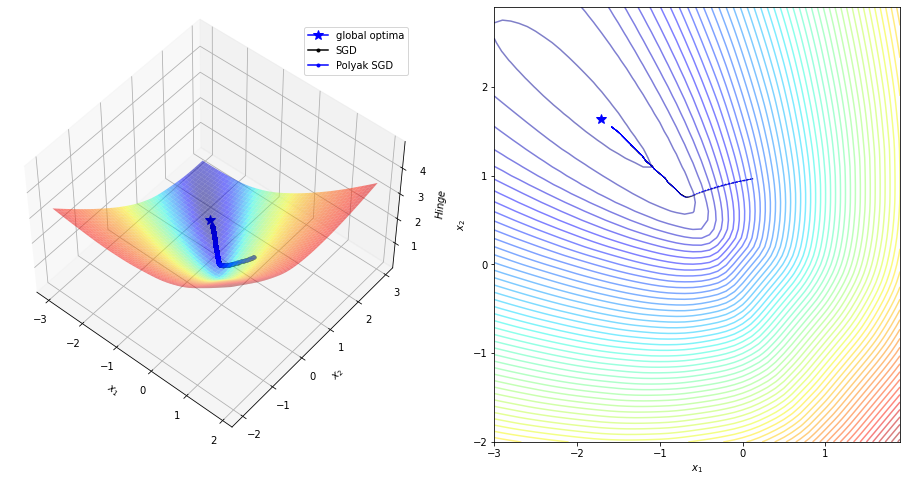

In [18]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='polyak', 
                              momentum=0.5, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='b', label='Polyak SGD')
hinge_loss_opt

In [19]:
polyak_primal_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_l1_svc_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_l1_svc_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_l1_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
polyak_primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    polyak   0.1   0.339631     0.975    1000    42
                1.0   0.365213     0.985    1000    18
                10.0  0.201533     0.980     467    10

Fitting 1 folds for each of 3 candidates, totalling 3 fits


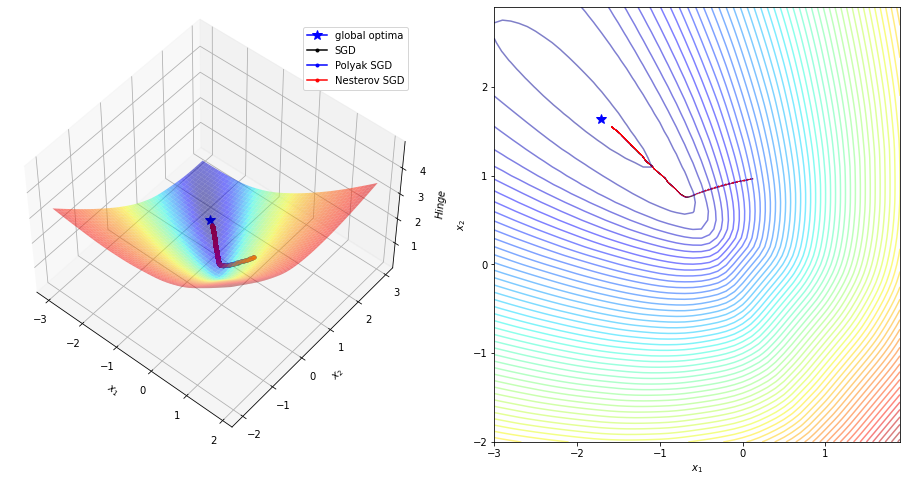

In [20]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.5, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='r', label='Nesterov SGD')
hinge_loss_opt.savefig('./tex/img/l1_svc_loss.png')
hinge_loss_opt

In [21]:
nesterov_primal_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_l1_svc_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_l1_svc_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_l1_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    nesterov 0.1   0.334495     0.975    1000    42
                1.0   0.372334     0.985    1000    18
                10.0  0.201525     0.980     472    10

In [22]:
custom_primal_l1_svc_cv_results = none_primal_l1_svc_cv_results.append(
    polyak_primal_l1_svc_cv_results).append(
    nesterov_primal_l1_svc_cv_results)
custom_primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    none     0.1   0.325569     0.970    1000    50
                1.0   0.358418     0.985    1000    24
                10.0  0.358465     0.980     947    10
       polyak   0.1   0.339631     0.975    1000    42
                1.0   0.365213     0.985    1000    18
                10.0  0.201533     0.980     467    10
       nesterov 0.1   0.334495     0.975    1000    42
                1.0   0.372334     0.985    1000    18
                10.0  0.201525     0.980     472    10

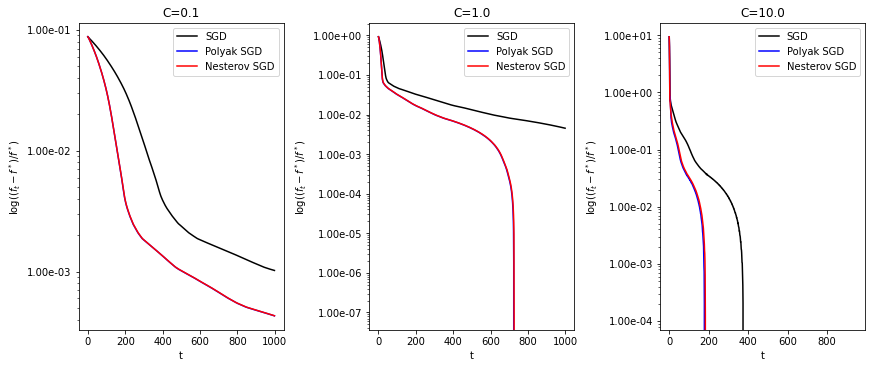

In [23]:
colors = {'none': ('k', 'SGD'),
          'polyak': ('b', 'Polyak SGD'),
          'nesterov': ('r', 'Nesterov SGD')}
axes = plt.figure(figsize=(12, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum][0], label=colors[momentum][1])
        loss.set_title('C={:.1f}'.format(C))
        loss.set_xlabel('t')
        loss.set_yscale('log')
        loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
        loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
        loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/l1_svc_loss_history.png')

In [24]:
grid = GridSearchCV(SkLinearSVC(loss='hinge', 
                                random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [25]:
liblinear_primal_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_l1_svc_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_l1_svc_cv_results.insert(1, 'momentum', '-')
liblinear_primal_l1_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                     
liblinear -        0.1   0.000890     0.980      31    37
                   1.0   0.001042     0.985     332    16
                   10.0  0.001294     0.985    1000     5

In [26]:
primal_l1_svc_cv_results = custom_primal_l1_svc_cv_results.append(liblinear_primal_l1_svc_cv_results)
primal_l1_svc_cv_results.to_latex('./tex/experiments/primal_l1_svc.tex', 
                                  caption='Primal $\protect \mathcal{L}_1$-SVC results', 
                                  label='primal_l1_svc_cv_results', position='H')
primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                     
sgd       none     0.1   0.325569     0.970    1000    50
                   1.0   0.358418     0.985    1000    24
                   10.0  0.358465     0.980     947    10
          polyak   0.1   0.339631     0.975    1000    42
                   1.0   0.365213     0.985    1000    18
                   10.0  0.201533     0.980     467    10
          nesterov 0.1   0.334495     0.975    1000    42
                   1.0   0.372334     0.985    1000    18
                   10.0  0.201525     0.980     472    10
liblinear -        0.1   0.000890     0.980      31    37
                   1.0   0.001042     0.985     332    16
                   10.0  0.001294     0.985    1000     5

### Dual formulations

In [27]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.svm.kernels import LinearKernel, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.constrained._base import LagrangianQuadratic
from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [28]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [29]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def dual_accuracy_scorer(svc, X, y):
    
    if(hasattr(svc, 'train_loss_history') and
                isinstance(svc.obj, LagrangianQuadratic)):
        
        # (f_t - f^*) / f^*
        f_star = np.full_like(svc.train_loss_history, svc.obj.f_star())
        dual = 'reg_bias' if svc.reg_intercept else 'unreg_bias'
        kernel = svc.kernel.__class__.__name__
        train_loss_history[dual][kernel][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                            np.maximum(abs(f_star), 1))
        
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (svc.iter if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


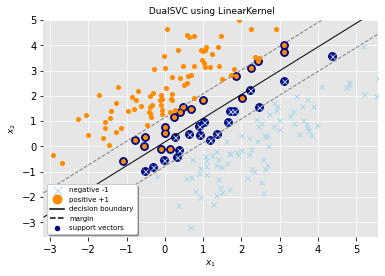

In [30]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            kernel=LinearKernel()),
                    param_grid={'C': [0.1, 1, 10],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_l1_svc_hyperplane.png')

In [31]:
custom_linear_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_l1_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_l1_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                     
cvxopt 0.1   0.028806     0.985       9    38
       1.0   0.035333     0.980      10    17
       10.0  0.039818     0.980      10    11
smo    0.1   0.050194     0.985      33    38
       1.0   0.035069     0.980      62    17
       10.0  0.104582     0.980     295    10

In [32]:
grid = GridSearchCV(SklSVC(kernel='linear', 
                           verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[LibSVM]

In [33]:
libsvm_linear_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_l1_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_l1_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                     
libsvm 0.1   0.002047     0.985      37    38
       1.0   0.002132     0.985     243    17
       10.0  0.002683     0.985     194    10

In [34]:
linear_dual_l1_svc_cv_results = custom_linear_dual_l1_svc_cv_results.append(libsvm_linear_dual_l1_svc_cv_results)
linear_dual_l1_svc_cv_results.sort_values(['solver'], ascending=False, inplace=True)
linear_dual_l1_svc_cv_results.to_latex('./tex/experiments/linear_dual_l1_svc.tex', 
                                       caption='Wolfe Dual linear $\protect \mathcal{L}_1$-SVC results', 
                                       label='linear_dual_l1_svc_cv_results', position='H')
linear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                     
smo    0.1   0.050194     0.985      33    38
       1.0   0.035069     0.980      62    17
       10.0  0.104582     0.980     295    10
libsvm 0.1   0.002047     0.985      37    38
       1.0   0.002132     0.985     243    17
       10.0  0.002683     0.985     194    10
cvxopt 0.1   0.028806     0.985       9    38
       1.0   0.035333     0.980      10    17
       10.0  0.039818     0.980      10    11

##### Nonlinear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


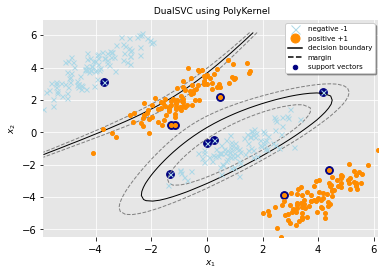

In [35]:
grid = GridSearchCV(DualSVC(loss=hinge),
                    param_grid={'C': [0.1, 1, 10],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_l1_svc_hyperplane.png')

In [36]:
poly_nonlinear_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_l1_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_l1_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                     
cvxopt poly   0.1   0.213058    0.8575      10   143
              1.0   0.256055    0.6775      10    31
              10.0  0.231667    0.9475      10    10
smo    poly   0.1   0.475808    0.8675     121   142
              1.0   0.386903    0.6825     143    30
              10.0  0.204837    0.9475      65    10

Fitting 1 folds for each of 6 candidates, totalling 6 fits


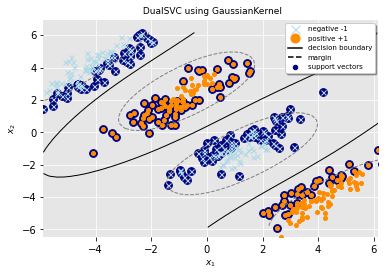

In [37]:
grid = GridSearchCV(DualSVC(loss=hinge),
                    param_grid={'C': [0.1, 1, 10],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_l1_svc_hyperplane.png')

In [38]:
rbf_nonlinear_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_l1_svc_cv_results.sort_values(['solver'], inplace=True)
rbf_nonlinear_dual_l1_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
rbf_nonlinear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                     
cvxopt rbf    0.1   0.172620       1.0      10   222
              1.0   0.240220       1.0      10    49
              10.0  0.239398       1.0      10    14
smo    rbf    0.1   0.392323       1.0      61   222
              1.0   0.353054       1.0      66    51
              10.0  0.203540       1.0      38    13

In [39]:
custom_nonlinear_dual_l1_svc_cv_results = poly_nonlinear_dual_l1_svc_cv_results.append(rbf_nonlinear_dual_l1_svc_cv_results)
custom_nonlinear_dual_l1_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                     
cvxopt poly   0.1   0.213058    0.8575      10   143
              1.0   0.256055    0.6775      10    31
              10.0  0.231667    0.9475      10    10
       rbf    0.1   0.172620    1.0000      10   222
              1.0   0.240220    1.0000      10    49
              10.0  0.239398    1.0000      10    14
smo    poly   0.1   0.475808    0.8675     121   142
              1.0   0.386903    0.6825     143    30
              10.0  0.204837    0.9475      65    10
       rbf    0.1   0.392323    1.0000      61   222
              1.0   0.353054    1.0000      66    51
              10.0  0.203540    1.0000      38    13

In [40]:
grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [0.1, 1, 10],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [0.1, 1, 10],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[LibSVM]

In [41]:
libsvm_nonlinear_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_l1_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_l1_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_l1_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                     
libsvm poly   0.1   0.005659       1.0     210   143
              1.0   0.004032       1.0     233    30
              10.0  0.002848       1.0     118    10
       rbf    0.1   0.006753       1.0     131   222
              1.0   0.003834       1.0     252    50
              10.0  0.002358       1.0     134    13

In [42]:
nonlinear_dual_l1_svc_cv_results = custom_nonlinear_dual_l1_svc_cv_results.append(libsvm_nonlinear_dual_l1_svc_cv_results)
nonlinear_dual_l1_svc_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_l1_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_l1_svc.tex', 
                                          caption='Wolfe Dual nonlinear $\protect \mathcal{L}_1$-SVC results', 
                                          label='nonlinear_dual_l1_svc_cv_results', position='H')
nonlinear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                     
smo    poly   0.1   0.475808    0.8675     121   142
              1.0   0.386903    0.6825     143    30
              10.0  0.204837    0.9475      65    10
       rbf    0.1   0.392323    1.0000      61   222
              1.0   0.353054    1.0000      66    51
              10.0  0.203540    1.0000      38    13
libsvm poly   0.1   0.005659    1.0000     210   143
              1.0   0.004032    1.0000     233    30
              10.0  0.002848    1.0000     118    10
       rbf    0.1   0.006753    1.0000     131   222
              1.0   0.003834    1.0000     252    50
              10.0  0.002358    1.0000     134    13
cvxopt poly   0.1   0.213058    0.8575      10   143
              1.0   0.256055    0.6775      10    31
              10.0  0.231667    0.9475      10    10
       rbf    0.1   0.172620    1.0000      10   222
              1.0   0.240220    1.0000      10    49
              10.0  0.239398    1.0000      10    14

#### Lagrangian Dual

##### Linear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/s

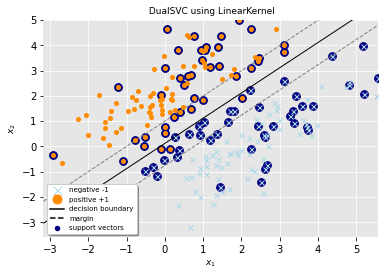

In [43]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            kernel=LinearKernel(), 
                            optimizer=AdaGrad, 
                            max_iter=10000, 
                            learning_rate=1.),
                    param_grid={'C': [0.1, 1, 10],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)

In [44]:
linear_lagrangian_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_l1_svc_cv_results.sort_values(['dual'], inplace=True)
linear_lagrangian_dual_l1_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_l1_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l1_svc.tex', 
                                                  caption='Lagrangian Dual linear $\protect \mathcal{L}_1$-SVC results', 
                                                  label='linear_lagrangian_dual_l1_svc_cv_results', position='H')
linear_lagrangian_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       C                                      
reg_bias   0.1   15.485357     0.985   10000   131
           1.0   12.431954     0.970   10000    94
           10.0  17.027144     0.970   10000   121
unreg_bias 0.1   16.659235     0.975   10000   136
           1.0   10.199121     0.980   10000   126
           10.0  12.724132     0.965   10000    70

##### Nonlinear

Fitting 1 folds for each of 12 candidates, totalling 12 fits


/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/s

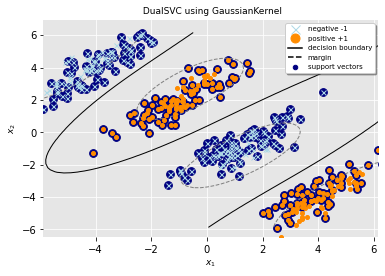

In [45]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            optimizer=AdaGrad, 
                            max_iter=10000, 
                            learning_rate=1.),
                    param_grid={'C': [0.1, 1, 10],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)

In [46]:
nonlinear_lagrangian_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_l1_svc_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_l1_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_l1_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l1_svc.tex', 
                                                     caption='Lagrangian Dual nonlinear $\protect \mathcal{L}_1$-SVC results', 
                                                     label='nonlinear_lagrangian_dual_l1_svc_cv_results', position='H')
nonlinear_lagrangian_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       kernel C                                      
reg_bias   poly   0.1   36.074888     0.790   10000   257
                  1.0   54.039554     0.875   10000   204
                  10.0  41.606979     0.790   10000   191
           rbf    0.1   63.063677     1.000   10000   310
                  1.0   44.399174     1.000   10000   213
                  10.0  37.221823     1.000   10000   182
unreg_bias poly   0.1   52.094757     0.845   10000   310
                  1.0   40.831654     0.750   10000   189
                  10.0  39.382344     0.780   10000   272
           rbf    0.1   97.217501     1.000   10000   313
                  1.0   34.413624     1.000   10000   215
                  10.0  36.789399     1.000   10000   215

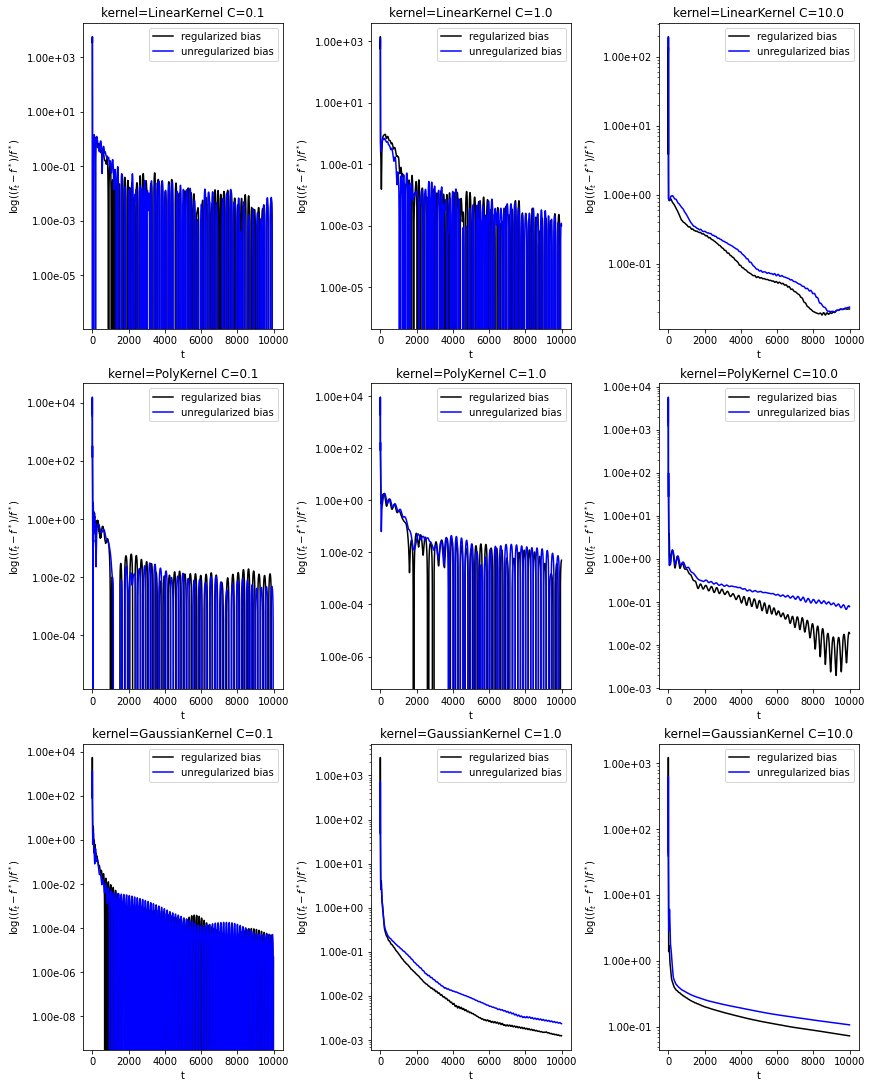

In [47]:
colors = {'reg_bias': ('k', 'regularized bias'),
          'unreg_bias': ('b', 'unregularized bias')}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for dual, _dict1 in train_loss_history.items():
    for (kernel, _dict2), row_ax in zip(_dict1.items(), axes):
        for (C, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[dual][0], label=colors[dual][1])
            loss.set_title('kernel={} C={:.1f}'.format(kernel, C))
            loss.set_xlabel('t')
            loss.set_yscale('log')
            loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
            loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
            loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/lagrangian_dual_l1_svc_loss_history.png')

## Squared Hinge loss

### Primal formulation

In [48]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [49]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    
    if hasattr(svc, 'train_loss_history'):
        
        # (f_t - f^*) / f^*
        f_star = np.full_like(svc.train_loss_history, svc.loss.f_star())
        train_loss_history[svc.momentum_type][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                                 np.maximum(abs(f_star), 1))
        
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(lin_X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits


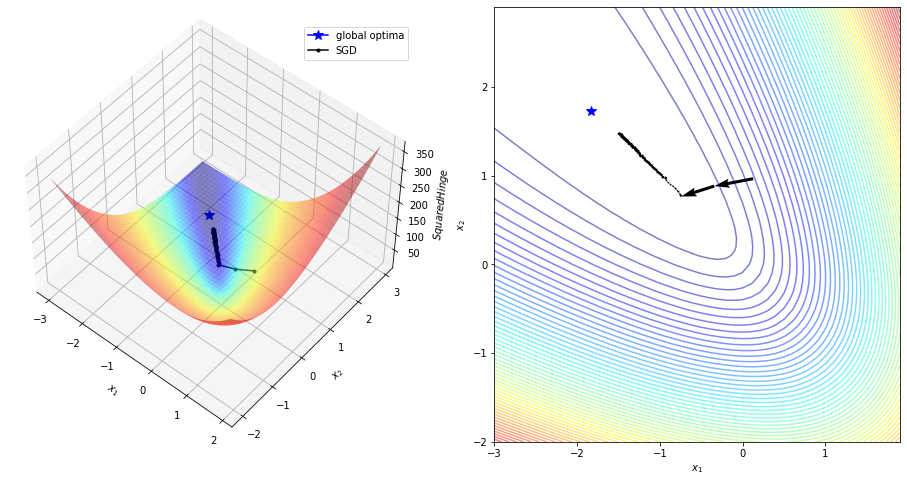

In [50]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

grid.best_estimator_.loss.x_opt = grid.best_estimator_.loss.x_star()[:-1] # remove the intercept weight to plot in 2D
grid.best_estimator_.loss.X = grid.best_estimator_.loss.X[:, :-1]  # remove the intercept column to plot in 2D
squared_hinge_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                          x_min=-3, x_max=2, y_min=-2, y_max=3)
squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss, grid.best_estimator_.optimizer, 
                                                      color='k', label='SGD')

In [51]:
none_primal_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_l2_svc_cv_results.insert(0, 'solver', 'sgd')
none_primal_l2_svc_cv_results.insert(1, 'momentum', 'none')
none_primal_l2_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    none     0.1   0.173259     0.975     488    49
                1.0   0.196758     0.980     433    24
                10.0  0.041189     0.985      57    21

Fitting 1 folds for each of 3 candidates, totalling 3 fits


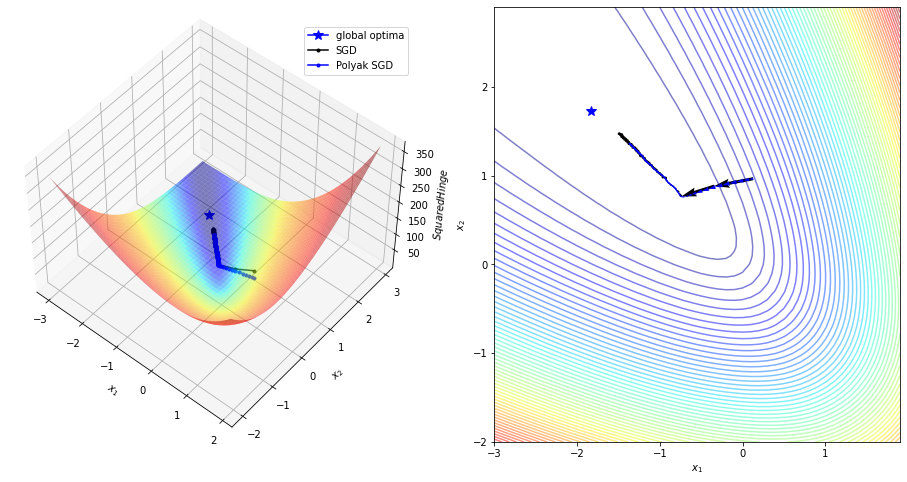

In [52]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='polyak', 
                              momentum=0.5, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='b', label='Polyak SGD')
squared_hinge_loss_opt

In [53]:
polyak_primal_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_l2_svc_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_l2_svc_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_l2_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
polyak_primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    polyak   0.1   0.087903     0.975     246    49
                1.0   0.127343     0.985     233    25
                10.0  0.018536     0.985      23    20

Fitting 1 folds for each of 3 candidates, totalling 3 fits


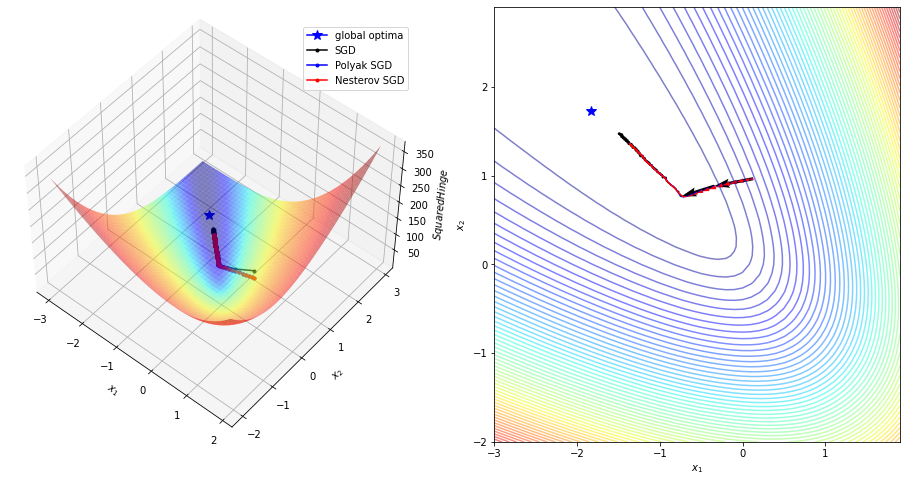

In [54]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.5, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='r', label='Nesterov SGD')
squared_hinge_loss_opt.savefig('./tex/img/l2_svc_loss.png')
squared_hinge_loss_opt

In [55]:
nesterov_primal_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_l2_svc_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_l2_svc_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_l2_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    nesterov 0.1   0.097543     0.975     247    49
                1.0   0.134696     0.985     234    23
                10.0  0.023753     0.985      30    18

In [56]:
custom_primal_l2_svc_cv_results = none_primal_l2_svc_cv_results.append(
    polyak_primal_l2_svc_cv_results).append(
    nesterov_primal_l2_svc_cv_results)
custom_primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    none     0.1   0.173259     0.975     488    49
                1.0   0.196758     0.980     433    24
                10.0  0.041189     0.985      57    21
       polyak   0.1   0.087903     0.975     246    49
                1.0   0.127343     0.985     233    25
                10.0  0.018536     0.985      23    20
       nesterov 0.1   0.097543     0.975     247    49
                1.0   0.134696     0.985     234    23
                10.0  0.023753     0.985      30    18

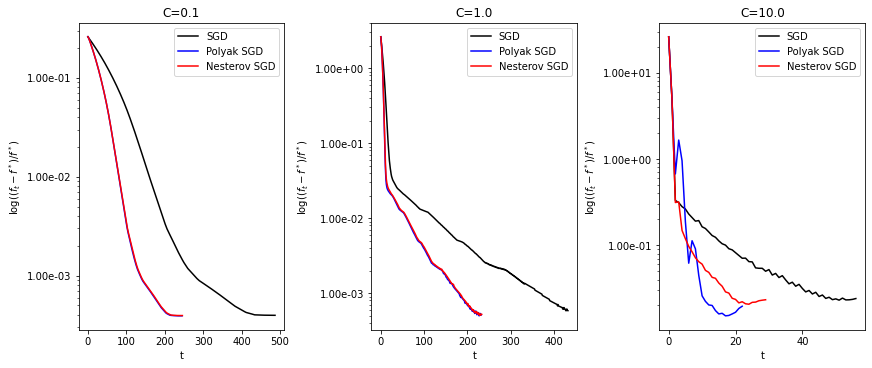

In [57]:
colors = {'none': ('k', 'SGD'),
          'polyak': ('b', 'Polyak SGD'),
          'nesterov': ('r', 'Nesterov SGD')}
axes = plt.figure(figsize=(12, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum][0], label=colors[momentum][1])
        loss.set_title('C={:.1f}'.format(C))
        loss.set_xlabel('t')
        loss.set_yscale('log')
        loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
        loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
        loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/l2_svc_loss_history.png')

In [58]:
grid = GridSearchCV(SkLinearSVC(loss='squared_hinge', 
                                random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [59]:
liblinear_primal_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_l2_svc_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_l2_svc_cv_results.insert(1, 'momentum', '-')
liblinear_primal_l2_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                     
liblinear -        0.1   0.001174      0.98      52    46
                   1.0   0.001623      0.98     563    25
                   10.0  0.002059      0.98    1000    19

In [60]:
primal_l2_svc_cv_results = custom_primal_l2_svc_cv_results.append(liblinear_primal_l2_svc_cv_results)
primal_l2_svc_cv_results.to_latex('./tex/experiments/primal_l2_svc.tex', 
                                  caption='Primal $\protect \mathcal{L}_2$-SVC results', 
                                  label='primal_l2_svc_cv_results', position='H')
primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                     
sgd       none     0.1   0.173259     0.975     488    49
                   1.0   0.196758     0.980     433    24
                   10.0  0.041189     0.985      57    21
          polyak   0.1   0.087903     0.975     246    49
                   1.0   0.127343     0.985     233    25
                   10.0  0.018536     0.985      23    20
          nesterov 0.1   0.097543     0.975     247    49
                   1.0   0.134696     0.985     234    23
                   10.0  0.023753     0.985      30    18
liblinear -        0.1   0.001174     0.980      52    46
                   1.0   0.001623     0.980     563    25
                   10.0  0.002059     0.980    1000    19

### Lagrangian Dual

In [61]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.svm.kernels import LinearKernel, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.constrained._base import LagrangianQuadratic
from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [62]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def dual_accuracy_scorer(svc, X, y):
    
    # (f_t - f^*) / f^*
    f_star = np.full_like(svc.train_loss_history, svc.obj.f_star())
    dual = 'reg_bias' if svc.reg_intercept else 'unreg_bias'
    kernel = svc.kernel.__class__.__name__
    train_loss_history[dual][kernel][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                        np.maximum(abs(f_star), 1))
    
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Linear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:968: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:968: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:968: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/s

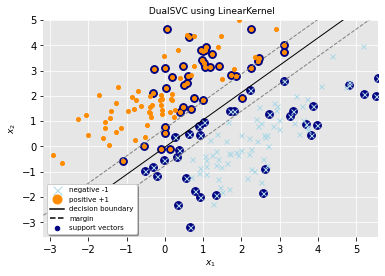

In [63]:
grid = GridSearchCV(DualSVC(loss=squared_hinge, 
                            kernel=LinearKernel(), 
                            optimizer=AdaGrad, 
                            max_iter=10000, 
                            learning_rate=1.),
                    param_grid={'C': [0.1, 1, 10],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)

In [64]:
linear_lagrangian_dual_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_l2_svc_cv_results.sort_values(['dual'], inplace=True)
linear_lagrangian_dual_l2_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_l2_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l2_svc.tex', 
                                                  caption='Lagrangian Dual linear $\protect \mathcal{L}_2$-SVC results', 
                                                  label='linear_lagrangian_dual_l2_svc_cv_results', position='H')
linear_lagrangian_dual_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       C                                      
reg_bias   0.1   11.991363     0.980   10000    46
           1.0   13.825833     0.985   10000   139
           10.0  13.258321     0.945   10000   101
unreg_bias 0.1   13.586800     0.980   10000    47
           1.0   13.451519     0.985   10000    85
           10.0  14.163535     0.965   10000    94

#### Nonlinear

Fitting 1 folds for each of 12 candidates, totalling 12 fits


/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:968: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:968: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:968: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/s

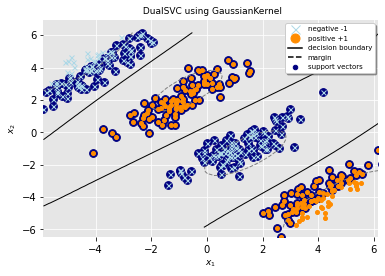

In [65]:
grid = GridSearchCV(DualSVC(loss=squared_hinge, 
                            optimizer=AdaGrad, 
                            max_iter=10000, 
                            learning_rate=1.),
                    param_grid={'C': [0.1, 1, 10],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)

In [66]:
nonlinear_lagrangian_dual_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_l2_svc_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_l2_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_l2_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l2_svc.tex', 
                                                     caption='Lagrangian Dual nonlinear $\protect \mathcal{L}_2$-SVC results', 
                                                     label='nonlinear_lagrangian_dual_l2_svc_cv_results', position='H')
nonlinear_lagrangian_dual_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       kernel C                                      
reg_bias   poly   0.1   24.693942    0.8675   10000   234
                  1.0   29.321871    1.0000   10000   273
                  10.0  33.523163    0.8225   10000   175
           rbf    0.1    5.595364    1.0000    3419   345
                  1.0   27.956911    1.0000   10000   130
                  10.0  33.733804    1.0000   10000   215
unreg_bias poly   0.1   21.976266    0.8625   10000   234
                  1.0   32.952900    1.0000   10000   196
                  10.0  34.304005    0.7775   10000   289
           rbf    0.1    9.661301    1.0000    5423   344
                  1.0   29.590797    1.0000   10000   254
                  10.0  29.038893    1.0000   10000   208

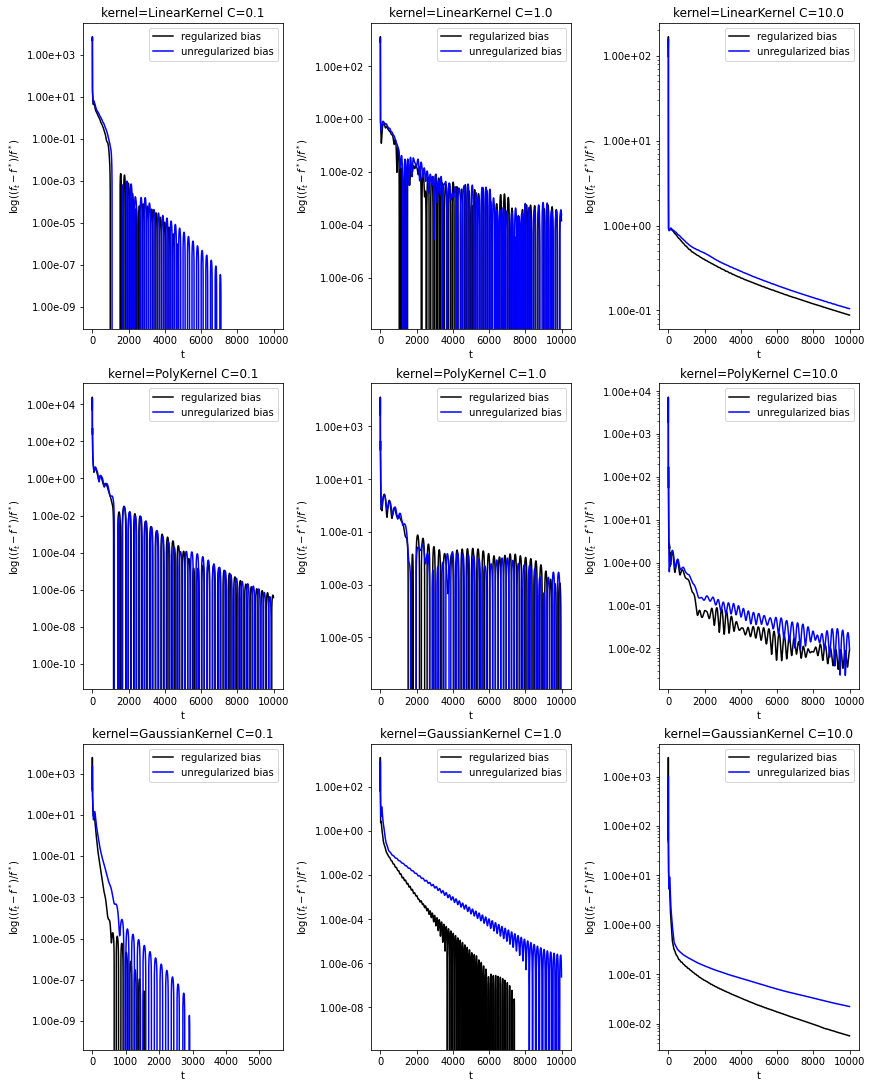

In [67]:
colors = {'reg_bias': ('k', 'regularized bias'),
          'unreg_bias': ('b', 'unregularized bias')}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for dual, _dict1 in train_loss_history.items():
    for (kernel, _dict2), row_ax in zip(_dict1.items(), axes):
        for (C, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[dual][0], label=colors[dual][1])
            loss.set_title('kernel={} C={:.1f}'.format(kernel, C))
            loss.set_xlabel('t')
            loss.set_yscale('log')
            loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
            loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
            loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/lagrangian_dual_l2_svc_loss_history.png')